<a href="https://colab.research.google.com/github/JSJeong-me/Detectron2/blob/main/aquarium-detectron3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# https://medium.com/red-buffer/training-an-object-detection-model-in-a-few-minutes-using-detectron2-5bd0aa5550d4

In [6]:
!pwd

/content


In [7]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [8]:
import torch

In [9]:
torch.__version__

'1.9.0+cu111'

In [ ]:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")

In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

In [1]:
!pwd

/content


In [ ]:
!ls -l

In [2]:
!cp /content/drive/MyDrive/Aquarium-coco.zip .

In [ ]:
!unzip ./Aquarium-coco.zip

In [4]:
!pwd

/content


In [6]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog

register_coco_instances('aquarium_train', {}, 'train/_annotations.coco.json', 'train')

register_coco_instances('aquarium_val', {}, 'valid/_annotations.coco.json', 'valid')
MetadataCatalog.get('aquarium_train').thing_classes = ['creatures', 'fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

Training

In [7]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os, json, cv2, random
from detectron2.engine import DefaultTrainer

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("aquarium_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00125
cfg.SOLVER.MAX_ITER = 1600
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here. (copied from the official detectron2 tutorial)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

Inference and Evaluation

In [12]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

[11/02 02:45:02 d2.data.datasets.coco]: Loaded 127 images in COCO format from valid/_annotations.coco.json


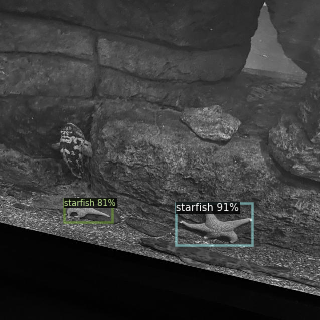

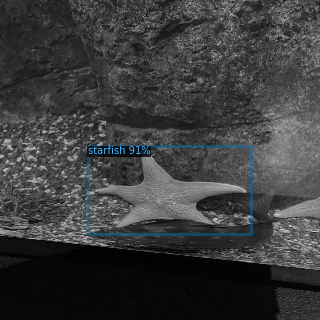

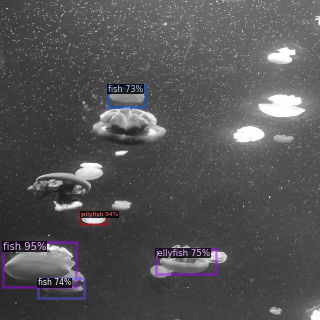

In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)


from detectron2.utils.visualizer import ColorMode
from detectron2.data.datasets import load_coco_json
dataset_dicts = load_coco_json("valid/_annotations.coco.json", "valid")
for d in random.sample(dataset_dicts, 3):
  im = cv2.imread(d['file_name'])
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
  metadata=MetadataCatalog.get('aquarium_train'),
  scale=0.5,
  instance_mode=ColorMode.IMAGE_BW)
  out = v.draw_instance_predictions(outputs['instances'].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("aquarium_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "aquarium_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

Saving and reloading the model

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

Saving and reloading the model

In [10]:
import torch
new_cfg = get_cfg()
new_cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
new_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8
new_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
new_cfg.MODEL.WEIGHTS = "./output/model_final.pth"

In [ ]:
im = cv2.imread('/content/test/IMG_2514_jpeg_jpg.rf.19de1787caef21dba070ac1b1c78e5e0.jpg')
outputs = predictor(im)


v = Visualizer(im[:, :, ::-1],
metadata=MetadataCatalog.get('aquarium_train'),
scale=2,
instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs['instances'].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [18]:
out